In [1]:
##############################################################################
#                                                                            #
#  Code for the USENIX Security '22 paper:                                   #
#  How Machine Learning Is Solving the Binary Function Similarity Problem.   #
#                                                                            #
#  MIT License                                                               #
#                                                                            #
#  Copyright (c) 2019-2022 Cisco Talos                                       #
#                                                                            #
#  Permission is hereby granted, free of charge, to any person obtaining     #
#  a copy of this software and associated documentation files (the           #
#  "Software"), to deal in the Software without restriction, including       #
#  without limitation the rights to use, copy, modify, merge, publish,       #
#  distribute, sublicense, and/or sell copies of the Software, and to        #
#  permit persons to whom the Software is furnished to do so, subject to     #
#  the following conditions:                                                 #
#                                                                            #
#  The above copyright notice and this permission notice shall be            #
#  included in all copies or substantial portions of the Software.           #
#                                                                            #
#  THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,           #
#  EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF        #
#  MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND                     #
#  NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE    #
#  LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION    #
#  OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION     #
#  WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.           #
#                                                                            #
#  AUC and similarity plots                                                  #
#                                                                            #
##############################################################################

In [2]:
import json
import math
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

from IPython.display import display
from collections import defaultdict
from sklearn import metrics, preprocessing

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

### Utility functions

In [3]:
def merge_data(df_pairs, df_similarity, is_pos):
    #df_pair: csv file (my output)
    #df_similarity (ground truth)
    df_pairs = df_pairs.merge(
        df_similarity,
        how='left',
        left_on=['idb_path_1', 'fva_1', 'idb_path_2', 'fva_2'],
        right_on=['idb_path_1', 'fva_1', 'idb_path_2', 'fva_2'])

    if is_pos:
        # If positive pairs, the perfect similarity is 1
        df_pairs['gt'] = [1] * df_pairs.shape[0]
    else:
        # if negative pairs, the perfect similarity is 0
        df_pairs['gt'] = [-1] * df_pairs.shape[0]

    return df_pairs

In [33]:
def plot_sim_and_roc(df_pos, df_neg, test_name, output_dir):
    result_list = list()
    task_list = sorted(set(df_pos['db_type']))

    plt_height = 10
    plt_width = 3
    if len(task_list) == 3:
        plt_height = 3
        plt_width
    if len(task_list) == 4:
        plt_height = 3
        plt_width = 4

    fig_auc, axs = plt.subplots(
        int(len(task_list) / plt_width),
        plt_width,
        figsize=(10, plt_height))
    axs = axs.reshape(-1, 1)

    sim_list = list()
    labels_list = list()

    for i, task in enumerate(task_list):
        df_pos_task = df_pos[df_pos['db_type'] == task]
        df_neg_task = df_neg[df_neg['db_type'] == task]

        sim_list.append(df_pos_task['sim'])
        sim_list.append(df_neg_task['sim'])

        labels_list.append('Pos (task: {})'.format(task))
        labels_list.append('Neg (task: {})'.format(task))

        pred_list = list(df_pos_task['sim'].values)
        pred_list += list(df_neg_task['sim'].values)
        gt_list = list(df_pos_task['gt'].values)
        gt_list += list(df_neg_task['gt'].values)

        # AUC
        roc_auc = metrics.roc_auc_score(gt_list, pred_list)
        result_list.append(["%20s" % (task), "%0.2f" % (roc_auc)])
        
        # Accuracy
        nb= len([index for index,value in enumerate(gt_list) if value ==1])
        print("percent of 1 in gt: {}".format(float(nb)/len(gt_list)))
        print("ground truth: {}".format(set(gt_list)))
        
        pos_pred = []
        neg_pred = []
        for ind, pred in enumerate(pred_list):
            if(gt_list[ind] == 1):
                pos_pred.append(pred)
            else:
                neg_pred.append(pred)
            
        print("A few + pred : {}".format(pos_pred[:20]))
        print("A few - pred : {}".format(neg_pred[:20]))
        pred_array = np.array(pred_list).reshape(1,-1)
        #print("A few normalized pred : {}".format(preprocessing.normalize(pred_array)[:20]))


        max_acc = 0
        max_acc_threshold = 0
        for threshold in (np.linspace(min(pred_list), -10,100)):
            
            pred_class_list = [ (1 if pred < threshold else -1) for pred in pred_list]
            accuracy = metrics.accuracy_score(gt_list, pred_class_list)
            print("Thresh {:.2f} -> acc {:.2f}".format(threshold, accuracy))
            if(max_acc < accuracy):
                max_acc = accuracy
                max_acc_threshold = threshold
            
        for threshold in (np.linspace(-10, -1,100)):
            pred_class_list = [ (1 if pred < threshold else -1) for pred in pred_list]
            accuracy = metrics.accuracy_score(gt_list, pred_class_list)
            print("Thresh {:.2f} -> acc {:.2f}".format(threshold, accuracy))

            if(max_acc < accuracy):
                max_acc = accuracy
                max_acc_threshold = threshold
                
        for threshold in (np.linspace(-1, max(pred_list),1000)):
            pred_class_list = [ (1 if pred < threshold else -1) for pred in pred_list]
            accuracy = metrics.accuracy_score(gt_list, pred_class_list)
            print("Thresh {:.2f} -> acc {:.2f}".format(threshold, accuracy))

            if(max_acc < accuracy):
                max_acc = accuracy
                max_acc_threshold = threshold
                
        print("Max accuracy of task: " + str(max_acc) + " with thresh: " + str(threshold))
            
        # FPR vs. TPR plot
        fpr, tpr, thresholds = metrics.roc_curve(gt_list, pred_list)
        p_axs = axs[i][0].plot(fpr, tpr, linewidth=1.0)
        axs[i][0].set_xlabel('FPR')
        axs[i][0].set_ylabel('TPR')
        axs[i][0].set_xlim([0, 1])
        axs[i][0].set_ylim([0, 1])
        axs[i][0].set_title("AUC = %0.2f - Task: %s" % (roc_auc, task))

    fig_auc.tight_layout()
    # fig_path = os.path.join(output_dir, "{}_roc.png".format(test_name))
    # plt.savefig(fig_path, dpi=300)
    plt.show()

    fig_bplot, axs = plt.subplots(figsize=(10, plt_height))
    bplot = axs.boxplot(
        x=sim_list[::-1],
        labels=labels_list[::-1],
        showfliers=False,
        patch_artist=True,
        vert=False)
    axs.set_title("Similarity distribution for positive and negative pairs")
    for c, patch in enumerate(bplot['boxes']):
        if c % 2:
            patch.set_facecolor('lightblue')
    # fig_path = os.path.join(output_dir, "{}_boxplot.png".format(test_name))
    # plt.savefig(fig_path, dpi=300)
    plt.show()

    return result_list

In [34]:
def compute_auc_and_plot(df_pos, df_neg, results_dir, output_dir):
    results = list()
    for csv_file in sorted(os.listdir(results_dir)):
        # for every POSITIVE .csv in the "result dir"
        # find the NEGATIVE counterpart
        # read them to DataFrames
        # check there are no NaN values
        # 
        
        if (not csv_file.endswith(".csv")) or \
                ("pos_testing" not in csv_file):
            continue

        print("[D] Processing\n\t{}\n\t{}".format(
            csv_file, csv_file.replace("pos_testing", "neg_testing")))
        
        test_name = csv_file.replace("pos_testing_", "")
        test_name = test_name.replace(".csv", "")

        df_pos_sim = pd.read_csv(
            os.path.join(results_dir, csv_file))

        df_neg_sim = pd.read_csv(
            os.path.join(results_dir, csv_file.replace(
                "pos_testing", "neg_testing")))

        print("Reading {}\n".format(os.path.join(results_dir, csv_file)))
        print("csv_file Headers: {}\n".format(df_pos_sim.columns))
        print("df_pos headers: {}".format(df_pos.columns))
        
        assert(df_pos_sim.isna().sum()['sim'] == 0)
        assert(df_neg_sim.isna().sum()['sim'] == 0)

        # Plot the similarity distribution
        df_pos_sim['sim'].hist(bins=200)
        df_neg_sim['sim'].hist(bins=200, alpha=0.8)
        print("Similarity distribution")

        # fig_path = os.path.join(output_dir, "{}_sim.png".format(test_name))
        # plt.savefig(fig_path, dpi=300)
        plt.show()

        # Merge
        df_pos_m = merge_data(df_pos, df_pos_sim, is_pos=True)
        df_neg_m = merge_data(df_neg, df_neg_sim, is_pos=False)
        print("Merged Headers: {}".format(df_pos_m.columns))

        # CALL to PLOT_SIM_AND_ROC
        tmp_list = [['title', test_name]]
        tmp_list.extend(plot_sim_and_roc(
            df_pos_m, df_neg_m, test_name, output_dir))
        results.append(tmp_list)
        
    return results

In [35]:
def from_list_to_df(auc_list):
    pd_temp_dict = defaultdict(list)
    for xr in auc_list:
        columns_set = set()
        columns = [x[0].strip() for x in xr]
        values = [x[1].strip() for x in xr]
        for c, v in zip(columns, values):
            columns_set.add(c)
            pd_temp_dict[c].append(v)
    df_auc = pd.DataFrame.from_dict(pd_temp_dict)
    df_auc = df_auc.rename(columns={"title":"model_name"})
    df_auc['model_name'] = df_auc['model_name'].apply(lambda x: x.replace("Dataset-1_", ""))
    df_auc['model_name'] = df_auc['model_name'].apply(lambda x: x.replace("Dataset-2-CodeCMR_", ""))
    df_auc['model_name'] = df_auc['model_name'].apply(lambda x: x.replace("Dataset-2_", ""))    
    return df_auc

In [36]:
# Create output folders
!mkdir -p metrics_and_plots/Dataset-1
!mkdir -p metrics_and_plots/Dataset-1-CodeCMR
!mkdir -p metrics_and_plots/Dataset-2

## Dataset 1

[D] Processing
	pos_testing_Dataset-2_sim.csv
	neg_testing_Dataset-2_sim.csv
Reading ../my_exp_data/Dataset-2_2/pos_testing_Dataset-2_sim.csv

csv_file Headers: Index(['Unnamed: 0', 'idb_path_1', 'fva_1', 'func_name_1', 'idb_path_2',
       'fva_2', 'func_name_2', 'sim'],
      dtype='object')

df_pos headers: Index(['Unnamed: 0', 'idb_path_1', 'fva_1', 'func_name_1', 'idb_path_2',
       'fva_2', 'func_name_2', 'db_type'],
      dtype='object')
Similarity distribution


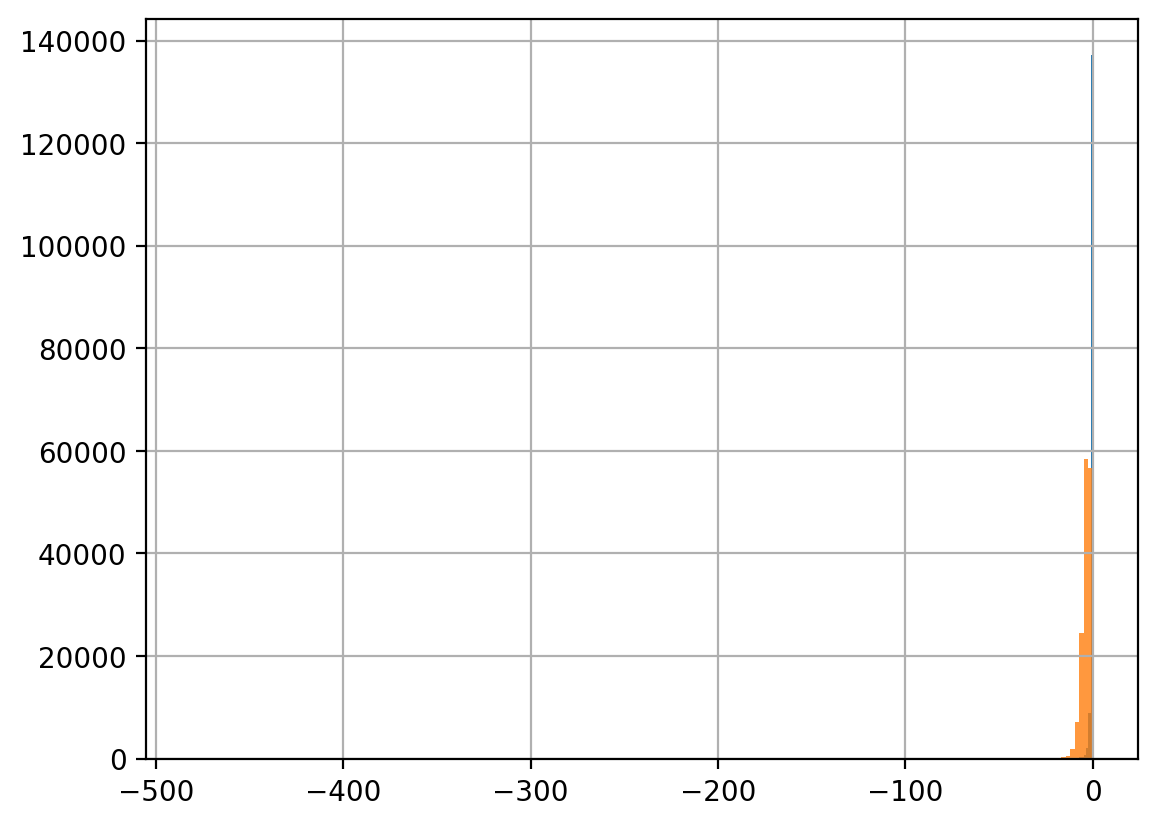

Merged Headers: Index(['Unnamed: 0_x', 'idb_path_1', 'fva_1', 'func_name_1_x', 'idb_path_2',
       'fva_2', 'func_name_2_x', 'db_type', 'Unnamed: 0_y', 'func_name_1_y',
       'func_name_2_y', 'sim', 'gt'],
      dtype='object')
percent of 1 in gt: 0.523316556089377
ground truth: {1, -1}
A few + pred : [-0.0344521, -0.012113194, -0.00326195, -0.15946917, -0.2692039, -0.9001043, -0.17837061, -2.2832518, -1.0396674, -0.005706585, -1.2179627, -0.12607217, -0.46249887, -0.19428921, -0.04951157, -0.07500903, -0.05878541, -0.02206378, -0.0668312, -0.0668312]
A few - pred : [-7.0944395, -2.671402, -4.1649384, -21.873169, -2.6439056, -4.019639, -7.0164943, -3.6218848, -2.858498, -3.6398807, -4.1654367, -1.5076449, -0.6123103, -4.1892786, -2.8292768, -3.4499173, -1.3556166, -5.6048226, -0.76429915, -4.148381]
Thresh -481.29 -> acc 0.48
Thresh -476.53 -> acc 0.48
Thresh -471.77 -> acc 0.48
Thresh -467.01 -> acc 0.48
Thresh -462.25 -> acc 0.48
Thresh -457.48 -> acc 0.48
Thresh -452.72 -> acc 0.4

Thresh -0.91 -> acc 0.10
Thresh -0.91 -> acc 0.10
Thresh -0.91 -> acc 0.10
Thresh -0.91 -> acc 0.10
Thresh -0.91 -> acc 0.10
Thresh -0.91 -> acc 0.10
Thresh -0.91 -> acc 0.10
Thresh -0.90 -> acc 0.10
Thresh -0.90 -> acc 0.10
Thresh -0.90 -> acc 0.10
Thresh -0.90 -> acc 0.10
Thresh -0.90 -> acc 0.10
Thresh -0.90 -> acc 0.10
Thresh -0.90 -> acc 0.10
Thresh -0.90 -> acc 0.10
Thresh -0.90 -> acc 0.10
Thresh -0.90 -> acc 0.10
Thresh -0.89 -> acc 0.10
Thresh -0.89 -> acc 0.10
Thresh -0.89 -> acc 0.10
Thresh -0.89 -> acc 0.10
Thresh -0.89 -> acc 0.10
Thresh -0.89 -> acc 0.10
Thresh -0.89 -> acc 0.10
Thresh -0.89 -> acc 0.10
Thresh -0.89 -> acc 0.10
Thresh -0.89 -> acc 0.10
Thresh -0.88 -> acc 0.10
Thresh -0.88 -> acc 0.10
Thresh -0.88 -> acc 0.10
Thresh -0.88 -> acc 0.10
Thresh -0.88 -> acc 0.10
Thresh -0.88 -> acc 0.10
Thresh -0.88 -> acc 0.10
Thresh -0.88 -> acc 0.10
Thresh -0.88 -> acc 0.10
Thresh -0.88 -> acc 0.10
Thresh -0.87 -> acc 0.10
Thresh -0.87 -> acc 0.10
Thresh -0.87 -> acc 0.10


Thresh -0.58 -> acc 0.10
Thresh -0.58 -> acc 0.10
Thresh -0.58 -> acc 0.10
Thresh -0.58 -> acc 0.10
Thresh -0.58 -> acc 0.10
Thresh -0.58 -> acc 0.10
Thresh -0.58 -> acc 0.10
Thresh -0.58 -> acc 0.10
Thresh -0.57 -> acc 0.10
Thresh -0.57 -> acc 0.10
Thresh -0.57 -> acc 0.10
Thresh -0.57 -> acc 0.10
Thresh -0.57 -> acc 0.10
Thresh -0.57 -> acc 0.10
Thresh -0.57 -> acc 0.10
Thresh -0.57 -> acc 0.10
Thresh -0.57 -> acc 0.10
Thresh -0.57 -> acc 0.10
Thresh -0.56 -> acc 0.10
Thresh -0.56 -> acc 0.10
Thresh -0.56 -> acc 0.10
Thresh -0.56 -> acc 0.10
Thresh -0.56 -> acc 0.10
Thresh -0.56 -> acc 0.10
Thresh -0.56 -> acc 0.10
Thresh -0.56 -> acc 0.10
Thresh -0.56 -> acc 0.10
Thresh -0.56 -> acc 0.10
Thresh -0.55 -> acc 0.11
Thresh -0.55 -> acc 0.11
Thresh -0.55 -> acc 0.11
Thresh -0.55 -> acc 0.11
Thresh -0.55 -> acc 0.11
Thresh -0.55 -> acc 0.11
Thresh -0.55 -> acc 0.11
Thresh -0.55 -> acc 0.11
Thresh -0.55 -> acc 0.11
Thresh -0.55 -> acc 0.11
Thresh -0.54 -> acc 0.11
Thresh -0.54 -> acc 0.11


Thresh -0.25 -> acc 0.13
Thresh -0.25 -> acc 0.13
Thresh -0.25 -> acc 0.13
Thresh -0.25 -> acc 0.13
Thresh -0.25 -> acc 0.13
Thresh -0.25 -> acc 0.13
Thresh -0.25 -> acc 0.13
Thresh -0.25 -> acc 0.14
Thresh -0.25 -> acc 0.14
Thresh -0.24 -> acc 0.14
Thresh -0.24 -> acc 0.14
Thresh -0.24 -> acc 0.14
Thresh -0.24 -> acc 0.14
Thresh -0.24 -> acc 0.14
Thresh -0.24 -> acc 0.14
Thresh -0.24 -> acc 0.14
Thresh -0.24 -> acc 0.14
Thresh -0.24 -> acc 0.14
Thresh -0.24 -> acc 0.14
Thresh -0.23 -> acc 0.14
Thresh -0.23 -> acc 0.14
Thresh -0.23 -> acc 0.14
Thresh -0.23 -> acc 0.14
Thresh -0.23 -> acc 0.14
Thresh -0.23 -> acc 0.14
Thresh -0.23 -> acc 0.14
Thresh -0.23 -> acc 0.14
Thresh -0.23 -> acc 0.14
Thresh -0.23 -> acc 0.14
Thresh -0.22 -> acc 0.14
Thresh -0.22 -> acc 0.14
Thresh -0.22 -> acc 0.14
Thresh -0.22 -> acc 0.14
Thresh -0.22 -> acc 0.14
Thresh -0.22 -> acc 0.14
Thresh -0.22 -> acc 0.14
Thresh -0.22 -> acc 0.14
Thresh -0.22 -> acc 0.14
Thresh -0.22 -> acc 0.14
Thresh -0.21 -> acc 0.14


Thresh -180.43 -> acc 0.46
Thresh -177.09 -> acc 0.46
Thresh -173.75 -> acc 0.46
Thresh -170.41 -> acc 0.46
Thresh -167.07 -> acc 0.46
Thresh -163.72 -> acc 0.46
Thresh -160.38 -> acc 0.46
Thresh -157.04 -> acc 0.46
Thresh -153.70 -> acc 0.46
Thresh -150.36 -> acc 0.46
Thresh -147.02 -> acc 0.46
Thresh -143.67 -> acc 0.46
Thresh -140.33 -> acc 0.46
Thresh -136.99 -> acc 0.46
Thresh -133.65 -> acc 0.46
Thresh -130.31 -> acc 0.46
Thresh -126.96 -> acc 0.46
Thresh -123.62 -> acc 0.46
Thresh -120.28 -> acc 0.46
Thresh -116.94 -> acc 0.46
Thresh -113.60 -> acc 0.46
Thresh -110.26 -> acc 0.46
Thresh -106.91 -> acc 0.46
Thresh -103.57 -> acc 0.46
Thresh -100.23 -> acc 0.46
Thresh -96.89 -> acc 0.46
Thresh -93.55 -> acc 0.46
Thresh -90.20 -> acc 0.46
Thresh -86.86 -> acc 0.46
Thresh -83.52 -> acc 0.46
Thresh -80.18 -> acc 0.46
Thresh -76.84 -> acc 0.46
Thresh -73.49 -> acc 0.46
Thresh -70.15 -> acc 0.46
Thresh -66.81 -> acc 0.46
Thresh -63.47 -> acc 0.46
Thresh -60.13 -> acc 0.46
Thresh -56.79

Thresh -0.82 -> acc 0.12
Thresh -0.82 -> acc 0.12
Thresh -0.82 -> acc 0.12
Thresh -0.82 -> acc 0.12
Thresh -0.82 -> acc 0.12
Thresh -0.82 -> acc 0.12
Thresh -0.82 -> acc 0.12
Thresh -0.81 -> acc 0.12
Thresh -0.81 -> acc 0.12
Thresh -0.81 -> acc 0.12
Thresh -0.81 -> acc 0.12
Thresh -0.81 -> acc 0.12
Thresh -0.81 -> acc 0.12
Thresh -0.81 -> acc 0.12
Thresh -0.81 -> acc 0.12
Thresh -0.81 -> acc 0.12
Thresh -0.81 -> acc 0.12
Thresh -0.80 -> acc 0.12
Thresh -0.80 -> acc 0.12
Thresh -0.80 -> acc 0.12
Thresh -0.80 -> acc 0.12
Thresh -0.80 -> acc 0.12
Thresh -0.80 -> acc 0.12
Thresh -0.80 -> acc 0.12
Thresh -0.80 -> acc 0.12
Thresh -0.80 -> acc 0.12
Thresh -0.80 -> acc 0.12
Thresh -0.79 -> acc 0.12
Thresh -0.79 -> acc 0.12
Thresh -0.79 -> acc 0.12
Thresh -0.79 -> acc 0.12
Thresh -0.79 -> acc 0.12
Thresh -0.79 -> acc 0.12
Thresh -0.79 -> acc 0.12
Thresh -0.79 -> acc 0.12
Thresh -0.79 -> acc 0.12
Thresh -0.79 -> acc 0.12
Thresh -0.78 -> acc 0.12
Thresh -0.78 -> acc 0.12
Thresh -0.78 -> acc 0.12


Thresh -0.49 -> acc 0.13
Thresh -0.49 -> acc 0.13
Thresh -0.49 -> acc 0.13
Thresh -0.49 -> acc 0.13
Thresh -0.48 -> acc 0.13
Thresh -0.48 -> acc 0.13
Thresh -0.48 -> acc 0.13
Thresh -0.48 -> acc 0.13
Thresh -0.48 -> acc 0.13
Thresh -0.48 -> acc 0.13
Thresh -0.48 -> acc 0.13
Thresh -0.48 -> acc 0.13
Thresh -0.48 -> acc 0.13
Thresh -0.48 -> acc 0.13
Thresh -0.47 -> acc 0.13
Thresh -0.47 -> acc 0.13
Thresh -0.47 -> acc 0.13
Thresh -0.47 -> acc 0.13
Thresh -0.47 -> acc 0.13
Thresh -0.47 -> acc 0.13
Thresh -0.47 -> acc 0.13
Thresh -0.47 -> acc 0.13
Thresh -0.47 -> acc 0.13
Thresh -0.47 -> acc 0.13
Thresh -0.46 -> acc 0.13
Thresh -0.46 -> acc 0.13
Thresh -0.46 -> acc 0.14
Thresh -0.46 -> acc 0.14
Thresh -0.46 -> acc 0.14
Thresh -0.46 -> acc 0.14
Thresh -0.46 -> acc 0.14
Thresh -0.46 -> acc 0.14
Thresh -0.46 -> acc 0.14
Thresh -0.46 -> acc 0.14
Thresh -0.45 -> acc 0.14
Thresh -0.45 -> acc 0.14
Thresh -0.45 -> acc 0.14
Thresh -0.45 -> acc 0.14
Thresh -0.45 -> acc 0.14
Thresh -0.45 -> acc 0.14


Thresh -0.16 -> acc 0.21
Thresh -0.16 -> acc 0.21
Thresh -0.16 -> acc 0.21
Thresh -0.15 -> acc 0.21
Thresh -0.15 -> acc 0.21
Thresh -0.15 -> acc 0.21
Thresh -0.15 -> acc 0.21
Thresh -0.15 -> acc 0.21
Thresh -0.15 -> acc 0.21
Thresh -0.15 -> acc 0.21
Thresh -0.15 -> acc 0.21
Thresh -0.15 -> acc 0.21
Thresh -0.15 -> acc 0.21
Thresh -0.14 -> acc 0.21
Thresh -0.14 -> acc 0.22
Thresh -0.14 -> acc 0.22
Thresh -0.14 -> acc 0.22
Thresh -0.14 -> acc 0.22
Thresh -0.14 -> acc 0.22
Thresh -0.14 -> acc 0.22
Thresh -0.14 -> acc 0.22
Thresh -0.14 -> acc 0.22
Thresh -0.14 -> acc 0.22
Thresh -0.13 -> acc 0.22
Thresh -0.13 -> acc 0.22
Thresh -0.13 -> acc 0.22
Thresh -0.13 -> acc 0.22
Thresh -0.13 -> acc 0.22
Thresh -0.13 -> acc 0.22
Thresh -0.13 -> acc 0.23
Thresh -0.13 -> acc 0.23
Thresh -0.13 -> acc 0.23
Thresh -0.13 -> acc 0.23
Thresh -0.12 -> acc 0.23
Thresh -0.12 -> acc 0.23
Thresh -0.12 -> acc 0.23
Thresh -0.12 -> acc 0.23
Thresh -0.12 -> acc 0.23
Thresh -0.12 -> acc 0.23
Thresh -0.12 -> acc 0.23


Thresh -6.55 -> acc 0.44
Thresh -6.45 -> acc 0.44
Thresh -6.36 -> acc 0.44
Thresh -6.27 -> acc 0.43
Thresh -6.18 -> acc 0.43
Thresh -6.09 -> acc 0.43
Thresh -6.00 -> acc 0.43
Thresh -5.91 -> acc 0.42
Thresh -5.82 -> acc 0.42
Thresh -5.73 -> acc 0.42
Thresh -5.64 -> acc 0.41
Thresh -5.55 -> acc 0.41
Thresh -5.45 -> acc 0.41
Thresh -5.36 -> acc 0.40
Thresh -5.27 -> acc 0.40
Thresh -5.18 -> acc 0.39
Thresh -5.09 -> acc 0.39
Thresh -5.00 -> acc 0.39
Thresh -4.91 -> acc 0.38
Thresh -4.82 -> acc 0.38
Thresh -4.73 -> acc 0.37
Thresh -4.64 -> acc 0.37
Thresh -4.55 -> acc 0.36
Thresh -4.45 -> acc 0.35
Thresh -4.36 -> acc 0.35
Thresh -4.27 -> acc 0.34
Thresh -4.18 -> acc 0.34
Thresh -4.09 -> acc 0.33
Thresh -4.00 -> acc 0.32
Thresh -3.91 -> acc 0.32
Thresh -3.82 -> acc 0.31
Thresh -3.73 -> acc 0.30
Thresh -3.64 -> acc 0.30
Thresh -3.55 -> acc 0.29
Thresh -3.45 -> acc 0.28
Thresh -3.36 -> acc 0.28
Thresh -3.27 -> acc 0.27
Thresh -3.18 -> acc 0.26
Thresh -3.09 -> acc 0.25
Thresh -3.00 -> acc 0.25


Thresh -0.73 -> acc 0.12
Thresh -0.73 -> acc 0.12
Thresh -0.73 -> acc 0.12
Thresh -0.73 -> acc 0.12
Thresh -0.73 -> acc 0.12
Thresh -0.73 -> acc 0.12
Thresh -0.73 -> acc 0.12
Thresh -0.73 -> acc 0.12
Thresh -0.73 -> acc 0.12
Thresh -0.72 -> acc 0.12
Thresh -0.72 -> acc 0.12
Thresh -0.72 -> acc 0.12
Thresh -0.72 -> acc 0.12
Thresh -0.72 -> acc 0.12
Thresh -0.72 -> acc 0.12
Thresh -0.72 -> acc 0.12
Thresh -0.72 -> acc 0.12
Thresh -0.72 -> acc 0.12
Thresh -0.72 -> acc 0.12
Thresh -0.71 -> acc 0.12
Thresh -0.71 -> acc 0.12
Thresh -0.71 -> acc 0.12
Thresh -0.71 -> acc 0.12
Thresh -0.71 -> acc 0.12
Thresh -0.71 -> acc 0.12
Thresh -0.71 -> acc 0.12
Thresh -0.71 -> acc 0.12
Thresh -0.71 -> acc 0.12
Thresh -0.71 -> acc 0.12
Thresh -0.70 -> acc 0.12
Thresh -0.70 -> acc 0.12
Thresh -0.70 -> acc 0.12
Thresh -0.70 -> acc 0.12
Thresh -0.70 -> acc 0.12
Thresh -0.70 -> acc 0.12
Thresh -0.70 -> acc 0.12
Thresh -0.70 -> acc 0.12
Thresh -0.70 -> acc 0.12
Thresh -0.70 -> acc 0.12
Thresh -0.69 -> acc 0.12


Thresh -0.40 -> acc 0.13
Thresh -0.40 -> acc 0.13
Thresh -0.40 -> acc 0.13
Thresh -0.40 -> acc 0.13
Thresh -0.40 -> acc 0.13
Thresh -0.40 -> acc 0.13
Thresh -0.40 -> acc 0.13
Thresh -0.40 -> acc 0.13
Thresh -0.39 -> acc 0.14
Thresh -0.39 -> acc 0.14
Thresh -0.39 -> acc 0.14
Thresh -0.39 -> acc 0.14
Thresh -0.39 -> acc 0.14
Thresh -0.39 -> acc 0.14
Thresh -0.39 -> acc 0.14
Thresh -0.39 -> acc 0.14
Thresh -0.39 -> acc 0.14
Thresh -0.39 -> acc 0.14
Thresh -0.38 -> acc 0.14
Thresh -0.38 -> acc 0.14
Thresh -0.38 -> acc 0.14
Thresh -0.38 -> acc 0.14
Thresh -0.38 -> acc 0.14
Thresh -0.38 -> acc 0.14
Thresh -0.38 -> acc 0.14
Thresh -0.38 -> acc 0.14
Thresh -0.38 -> acc 0.14
Thresh -0.38 -> acc 0.14
Thresh -0.37 -> acc 0.14
Thresh -0.37 -> acc 0.14
Thresh -0.37 -> acc 0.14
Thresh -0.37 -> acc 0.14
Thresh -0.37 -> acc 0.14
Thresh -0.37 -> acc 0.14
Thresh -0.37 -> acc 0.14
Thresh -0.37 -> acc 0.14
Thresh -0.37 -> acc 0.14
Thresh -0.37 -> acc 0.14
Thresh -0.36 -> acc 0.14
Thresh -0.36 -> acc 0.14


Thresh -0.07 -> acc 0.27
Thresh -0.07 -> acc 0.27
Thresh -0.07 -> acc 0.27
Thresh -0.07 -> acc 0.27
Thresh -0.07 -> acc 0.27
Thresh -0.06 -> acc 0.27
Thresh -0.06 -> acc 0.27
Thresh -0.06 -> acc 0.27
Thresh -0.06 -> acc 0.28
Thresh -0.06 -> acc 0.28
Thresh -0.06 -> acc 0.28
Thresh -0.06 -> acc 0.28
Thresh -0.06 -> acc 0.28
Thresh -0.06 -> acc 0.28
Thresh -0.06 -> acc 0.28
Thresh -0.05 -> acc 0.29
Thresh -0.05 -> acc 0.29
Thresh -0.05 -> acc 0.29
Thresh -0.05 -> acc 0.29
Thresh -0.05 -> acc 0.29
Thresh -0.05 -> acc 0.29
Thresh -0.05 -> acc 0.30
Thresh -0.05 -> acc 0.30
Thresh -0.05 -> acc 0.30
Thresh -0.05 -> acc 0.30
Thresh -0.04 -> acc 0.30
Thresh -0.04 -> acc 0.31
Thresh -0.04 -> acc 0.31
Thresh -0.04 -> acc 0.31
Thresh -0.04 -> acc 0.31
Thresh -0.04 -> acc 0.31
Thresh -0.04 -> acc 0.32
Thresh -0.04 -> acc 0.32
Thresh -0.04 -> acc 0.32
Thresh -0.04 -> acc 0.32
Thresh -0.03 -> acc 0.32
Thresh -0.03 -> acc 0.33
Thresh -0.03 -> acc 0.33
Thresh -0.03 -> acc 0.33
Thresh -0.03 -> acc 0.34


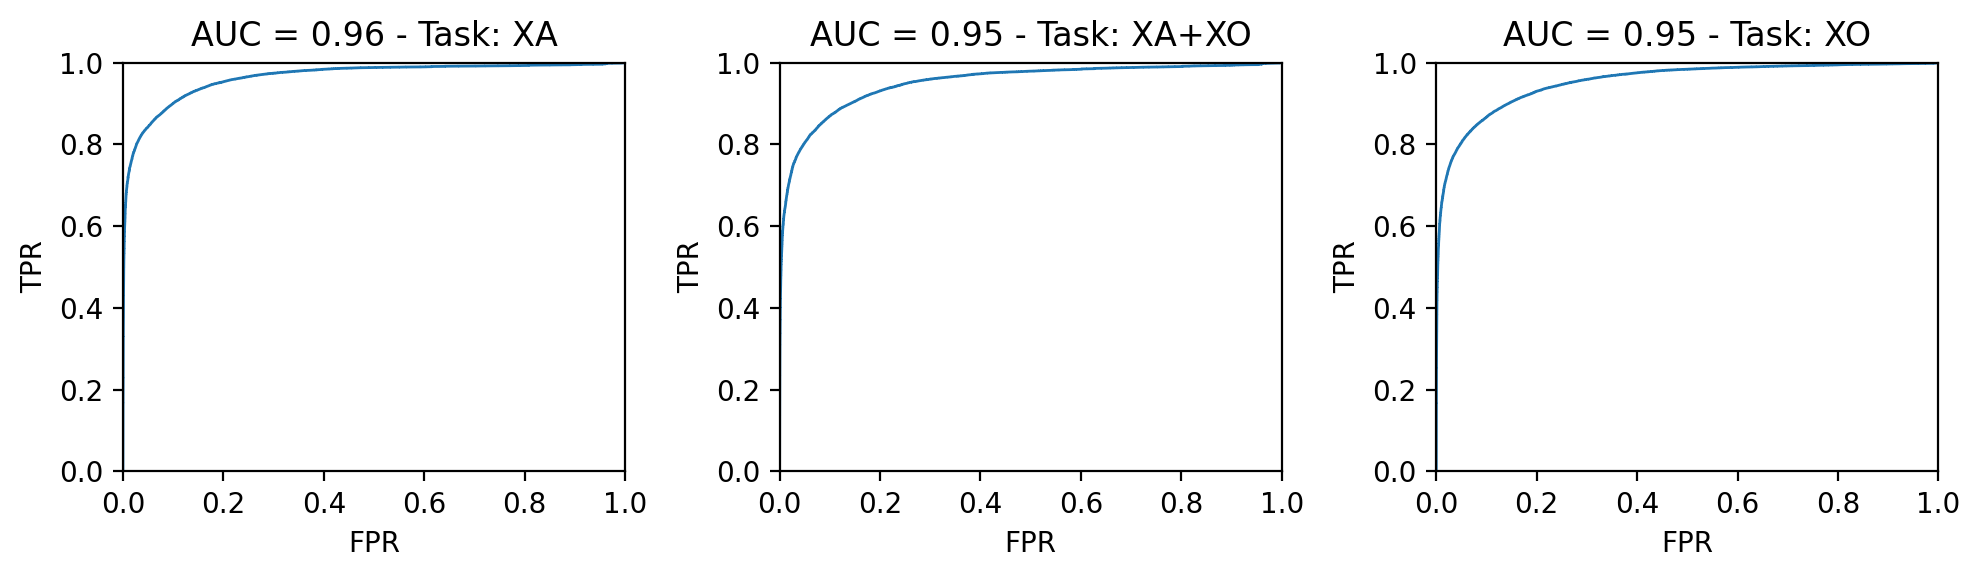

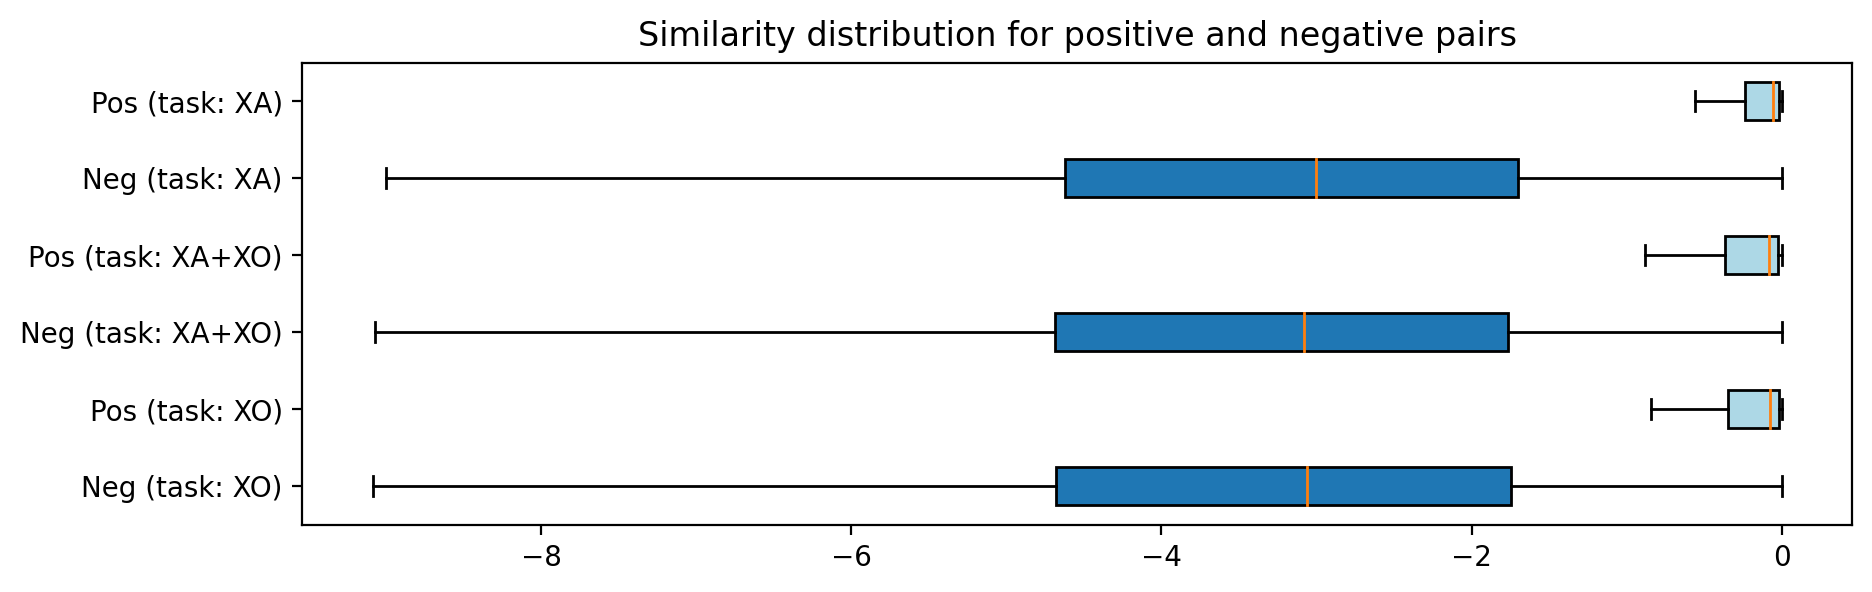

,model_name,XA,XA+XO,XO
0,sim,0.96,0.95,0.95


Saved file in ../my_exp_data/Dataset-2_2/df_auc.csv


In [37]:
RESULTS_DIR = "../my_exp_data/Dataset-2_2/"
OUTPUT_DIR = "../my_exp_data/Dataset-2_2/"

# NOTE: this will crash if you don't delete the "db_type" column in the outputted files
# during model inference

base_path = "../../DBs/Dataset-2/pairs/"

df_pos_testing = pd.read_csv(
    os.path.join(base_path, "pos_testing_Dataset-2.csv"))

df_neg_testing = pd.read_csv(
    os.path.join(base_path, "neg_testing_Dataset-2.csv"))

auc_list = compute_auc_and_plot(df_pos_testing, df_neg_testing, RESULTS_DIR, OUTPUT_DIR)
df_auc = from_list_to_df(auc_list)    
display(df_auc)
df_auc.to_csv(os.path.join(OUTPUT_DIR, "df_auc.csv"))
print("Saved file in {}".format(os.path.join(OUTPUT_DIR, "df_auc.csv")))

In [16]:
#RESULTS_DIR = "../data/Dataset-1-CodeCMR/"
#OUTPUT_DIR = "metrics_and_plots/Dataset-1-CodeCMR/"

#base_path = "../../DBs/Dataset-1-CodeCMR/pairs/testing/"

#df_pos_testing = pd.read_csv(
#    os.path.join(base_path, "pos_testing_Dataset-1-CodeCMR.csv"))

#df_neg_testing = pd.read_csv(
#    os.path.join(base_path, "neg_testing_Dataset-1-CodeCMR.csv"))

#auc_list = results = compute_auc_and_plot(df_pos_testing, df_neg_testing, RESULTS_DIR, OUTPUT_DIR)
#df_auc = from_list_to_df(auc_list)    
#display(df_auc)
#df_auc.to_csv(os.path.join(OUTPUT_DIR, "df_auc.csv"))

## Dataset 1-CodeCMR

## Dataset 2

In [ ]:
RESULTS_DIR = "../data/Dataset-2/"
OUTPUT_DIR = "metrics_and_plots/Dataset-2/"

base_path = "../../DBs/Dataset-2/pairs/"

df_pos_testing = pd.read_csv(
    os.path.join(base_path, "pos_testing_Dataset-2.csv"))

df_neg_testing = pd.read_csv(
    os.path.join(base_path, "neg_testing_Dataset-2.csv"))

auc_list = compute_auc_and_plot(df_pos_testing, df_neg_testing, RESULTS_DIR, OUTPUT_DIR)
df_auc = from_list_to_df(auc_list)    
display(df_auc)
df_auc.to_csv(os.path.join(OUTPUT_DIR, "df_auc.csv"))